# Collaborative based Explainable Recommendation Systems

In [ ]:
import pandas as pd

# Load the MovieLens dataset
data_url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(data_url, sep='\t', names=columns)

# Drop timestamp and print basic info
ratings.drop("timestamp", axis=1, inplace=True)
print(ratings.head())

   user_id  item_id  rating
0      196      242       3
1      186      302       3
2       22      377       1
3      244       51       2
4      166      346       1


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Create a user-item matrix
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Apply Truncated SVD
svd = TruncatedSVD(n_components=50)
matrix_reduced = svd.fit_transform(user_item_matrix)

# Compute similarities
user_similarity = cosine_similarity(matrix_reduced)
item_similarity = cosine_similarity(matrix_reduced.T)

# Example: Similar users for a given user
user_index = 0
similar_users = np.argsort(user_similarity[user_index])[::-1][:5]
print("Top similar users for user {}: {}".format(user_index + 1, similar_users + 1))

Top similar users for user 1: [  1 268 514 916 417]


In [ ]:
import numpy as np

def recommend_and_explain(user_id, user_item_matrix, user_similarity, top_n=5):
    # Adjust for 1-based index in user_item_matrix
    adjusted_user_id = user_id + 1  # Convert 0-based user_id to match 1-based index

    # Check if the user_id exists in the DataFrame index
    if adjusted_user_id not in user_item_matrix.index:
        print(f"User ID {adjusted_user_id} not found in the index.")
        return []

    # Fetch the user's ratings
    user_ratings = user_item_matrix.loc[adjusted_user_id]

    # Find unrated items
    unrated_items = user_ratings[user_ratings == 0].index

    # Compute scores for unrated items
    scores = []
    for item in unrated_items:
        # Get similar users based on user_similarity
        similar_users = np.argsort(-user_similarity[user_id])  # user_id is 0-based
        score = sum(
            user_similarity[user_id, other_user - 1] * user_item_matrix.loc[other_user, item]
            for other_user in similar_users[:5] if other_user in user_item_matrix.index and user_item_matrix.loc[other_user, item] > 0
        )
        scores.append((item, score))

    # Sort items by score
    ranked_items = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]

    # Explain recommendations
    explanations = []
    for item, score in ranked_items:
        similar_users = [
            other_user for other_user in similar_users[:5]
            if other_user in user_item_matrix.index and user_item_matrix.loc[other_user, item] > 0
        ]
        explanation = f"Recommended item {item} because similar users ({similar_users}) rated it highly."
        explanations.append((item, explanation))

    return explanations

# Example: Recommend and explain for user 0
recommendations = recommend_and_explain(0, user_item_matrix, user_similarity)  # Adjusted for 0-based input
for item, explanation in recommendations:
    print(explanation)


Recommended item 739 because similar users ([267, 513, 416]) rated it highly.
Recommended item 515 because similar users ([267, 416]) rated it highly.
Recommended item 614 because similar users ([267, 416]) rated it highly.
Recommended item 405 because similar users ([267, 416]) rated it highly.
Recommended item 433 because similar users ([267, 416]) rated it highly.


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for predictions
def calculate_rmse(true_ratings, predicted_ratings):
    mse = mean_squared_error(true_ratings, predicted_ratings)
    return np.sqrt(mse)

# Example: Predict ratings and compute RMSE
predicted_ratings = svd.inverse_transform(matrix_reduced)
rmse = calculate_rmse(user_item_matrix.values.flatten(), predicted_ratings.flatten())
print("RMSE:", rmse)

RMSE: 0.5811782674303317


# User Similarity Heatmap

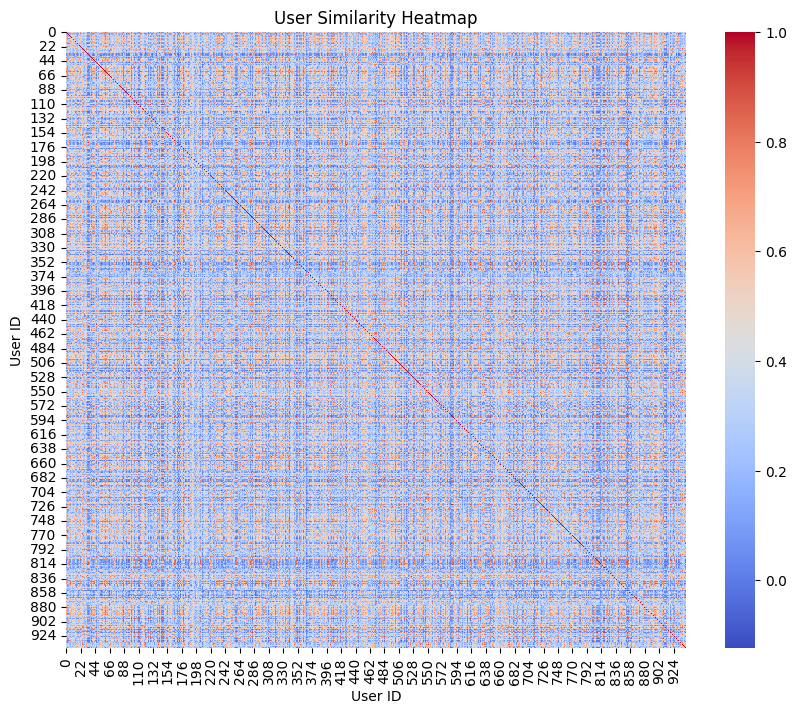

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming user_similarity is a 2D numpy array
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity, cmap="coolwarm", annot=False, cbar=True)
plt.title("User Similarity Heatmap")
plt.xlabel("User ID")
plt.ylabel("User ID")
plt.show()



## Plot similarity scores of User 1 with all other users

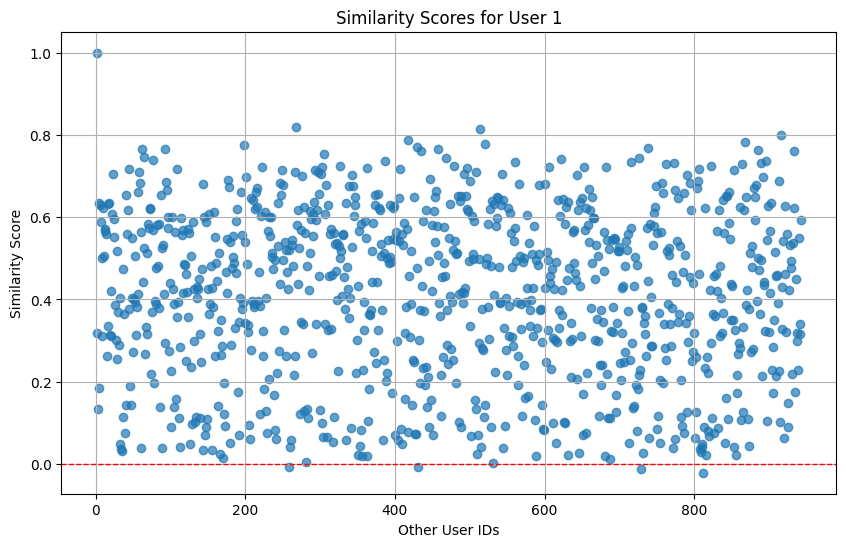

In [ ]:
import numpy as np

user_id = 0  # Zero-based indexing
user_similarities = user_similarity[user_id]

plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(user_similarities) + 1), user_similarities, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title(f"Similarity Scores for User {user_id + 1}")
plt.xlabel("Other User IDs")
plt.ylabel("Similarity Score")
plt.grid()
plt.show()


# Create a graph from the similarity matrix

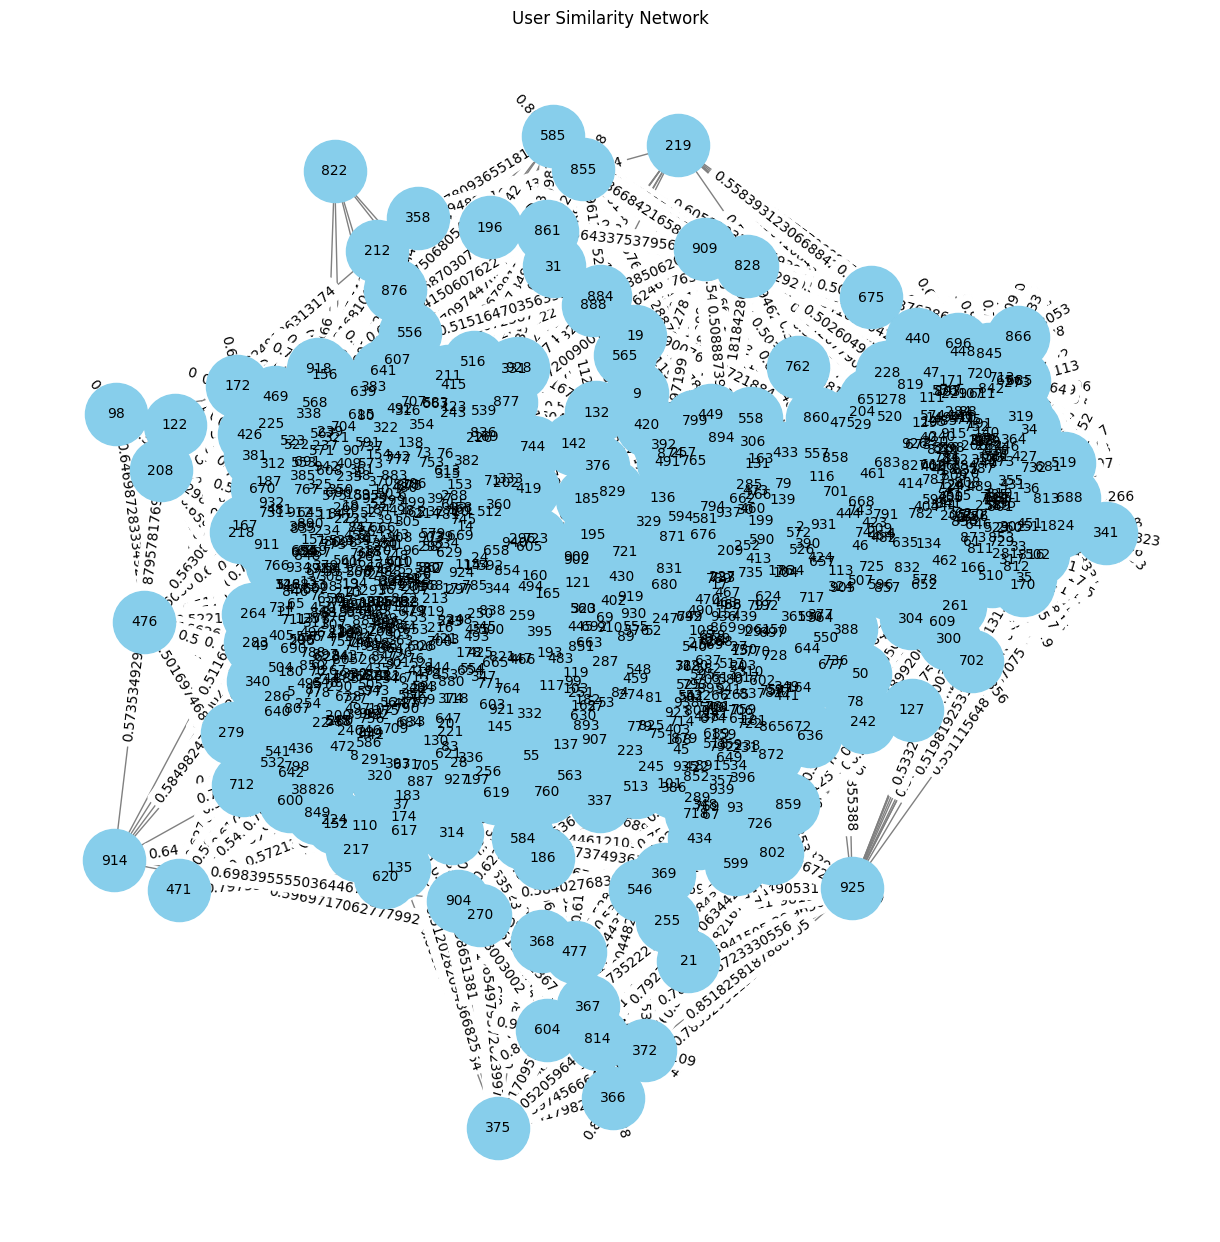

In [ ]:
import networkx as nx

G = nx.Graph()

# Add nodes
num_users = user_similarity.shape[0]
for i in range(num_users):
    G.add_node(i + 1)

# Add edges for high similarity scores
threshold = 0.5  # Define a threshold for similarity
for i in range(num_users):
    for j in range(i + 1, num_users):
        if user_similarity[i, j] > threshold:
            G.add_edge(i + 1, j + 1, weight=user_similarity[i, j])

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000, edge_color="gray", font_size=10)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("User Similarity Network")
plt.show()


# Get the top N similar users for a specific user

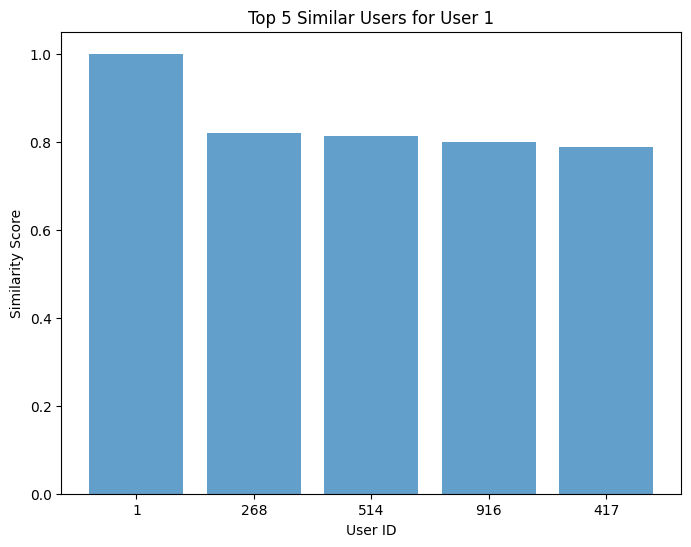

In [ ]:
user_id = 0  # Zero-based indexing
top_n = 5
similar_users = np.argsort(-user_similarity[user_id])[:top_n]
similar_scores = user_similarity[user_id, similar_users]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, top_n + 1), similar_scores, tick_label=similar_users + 1, alpha=0.7)
plt.title(f"Top {top_n} Similar Users for User {user_id + 1}")
plt.xlabel("User ID")
plt.ylabel("Similarity Score")
plt.show()
